In [14]:
# CELL 1: Setup
import sys
import subprocess

major, minor = sys.version_info[:2]
if not (major == 3 and minor >= 11):
    print(f"❌ Python {major}.{minor} - need 3.11+")
    raise SystemExit
print(f"✅ Python {major}.{minor} OK")

pip_ver = subprocess.check_output(["pip", "--version"]).decode().split()[1]
if not pip_ver.startswith("25"):
    !pip install --upgrade pip==25.*
    print("✅ pip 25 installed. RESTART runtime!")
else:
    print("✅ pip OK")

✅ Python 3.12 OK
✅ pip OK


In [15]:
# # install iqm-client with qrisp extras
# !pip install -U "iqm-client>=33.0.1" "qrisp[iqm]"
# # used for visualization
# !pip install matplotlib

from qrisp.interface import IQMBackend

# ============================================
# CONFIGURATION - CHANGE THESE AS NEEDED
# ============================================
API_TOKEN = "0BxDKLsx1RoyfbioinX+frtggTLn4f4MODh5iu7056QBnBUYECp/AbxEOFSxK+jV"
DEVICE = "emerald"  # Changed from sirius to garnet to emerald!

quantum_computer = IQMBackend(
    api_token = API_TOKEN,
    device_instance = DEVICE
)

print(f"✅ Connected to IQM {DEVICE.upper()}!")

✅ Connected to IQM EMERALD!


In [16]:
from iqm.qiskit_iqm import IQMProvider

provider = IQMProvider("https://resonance.meetiqm.com",
                       quantum_computer="emerald",
                       token="0BxDKLsx1RoyfbioinX+frtggTLn4f4MODh5iu7056QBnBUYECp/AbxEOFSxK+jV")
backend = provider.get_backend()

In [17]:
from qiskit import QuantumCircuit, transpile
import numpy as np
from matplotlib import pyplot as plt
import networkx as nx
from collections import deque

In [24]:
# CELL 2: CALIBRATION DATA

# ========== QUBIT READOUT ERRORS ==========
READOUT_P10 = {  # P(measure 1 | true 0)
    'QB1': 0.0125, 'QB2': 0.0060, 'QB3': 0.0100, 'QB4': 0.0120, 'QB5': 0.0125,
    'QB6': 0.0100, 'QB7': 0.0405, 'QB8': 0.0065, 'QB9': 0.0185, 'QB10': 0.0170,
    'QB11': 0.0095, 'QB12': 0.0140, 'QB13': 0.0180, 'QB14': 0.0160, 'QB15': 0.0125,
    'QB16': 0.0040, 'QB17': 0.0115, 'QB18': 0.0105, 'QB19': 0.0165, 'QB20': 0.0225,
    'QB21': 0.0100, 'QB22': 0.0205, 'QB23': 0.0065, 'QB24': 0.0135, 'QB25': 0.0195,
    'QB26': 0.0080, 'QB27': 0.0085, 'QB28': 0.0105, 'QB29': 0.0280, 'QB30': 0.0175,
    'QB31': 0.0730, 'QB32': 0.0220, 'QB33': 0.0065, 'QB34': 0.0090, 'QB35': 0.0210,
    'QB36': 0.0115, 'QB37': 0.0145, 'QB38': 0.0170, 'QB39': 0.0245, 'QB40': 0.0195,
    'QB41': 0.0185, 'QB42': 0.0235, 'QB43': 0.0165, 'QB44': 0.0150, 'QB45': 0.0290,
    'QB46': 0.0295, 'QB47': 0.0215, 'QB48': 0.0145, 'QB49': 0.0150, 'QB50': 0.0195,
    'QB51': 0.0180, 'QB52': 0.0185, 'QB53': 0.0145, 'QB54': 0.0175
}

READOUT_P01 = {  # P(measure 0 | true 1)
    'QB1': 0.0230, 'QB2': 0.0190, 'QB3': 0.0240, 'QB4': 0.1585, 'QB5': 0.0425,
    'QB6': 0.0105, 'QB7': 0.0505, 'QB8': 0.0160, 'QB9': 0.0235, 'QB10': 0.0275,
    'QB11': 0.0230, 'QB12': 0.0255, 'QB13': 0.0190, 'QB14': 0.0210, 'QB15': 0.0290,
    'QB16': 0.0135, 'QB17': 0.0275, 'QB18': 0.0115, 'QB19': 0.0205, 'QB20': 0.0200,
    'QB21': 0.0155, 'QB22': 0.0175, 'QB23': 0.0130, 'QB24': 0.0260, 'QB25': 0.0220,
    'QB26': 0.0195, 'QB27': 0.0190, 'QB28': 0.0730, 'QB29': 0.0690, 'QB30': 0.0290,
    'QB31': 0.0400, 'QB32': 0.0240, 'QB33': 0.0220, 'QB34': 0.0155, 'QB35': 0.0300,
    'QB36': 0.0135, 'QB37': 0.0400, 'QB38': 0.0255, 'QB39': 0.0270, 'QB40': 0.0395,
    'QB41': 0.0175, 'QB42': 0.0320, 'QB43': 0.0145, 'QB44': 0.0985, 'QB45': 0.0195,
    'QB46': 0.0315, 'QB47': 0.0445, 'QB48': 0.0200, 'QB49': 0.0160, 'QB50': 0.0205,
    'QB51': 0.0815, 'QB52': 0.0315, 'QB53': 0.0250, 'QB54': 0.0625
}

# ========== 2-QUBIT CZ GATE FIDELITIES ==========
# ЭТО КРИТИЧЕСКИ ВАЖНО! Раньше не использовалось!
CZ_FIDELITY = {
    # Best gates (>99%)
    'QB45__QB51': 0.9991,
    'QB31__QB39': 0.9985,
    'QB9__QB3': 0.9982,
    'QB11__QB19': 0.9982,
    'QB41__QB42': 0.9981,
    'QB53__QB49': 0.9980,
    'QB23__QB15': 0.9979,
    'QB29__QB28': 0.9978,
    'QB11__QB12': 0.9977,
    'QB1__QB2': 0.9977,
    'QB20__QB19': 0.9977,
    'QB34__QB33': 0.9975,
    'QB48__QB49': 0.9974,
    'QB18__QB19': 0.9971,
    'QB41__QB40': 0.9970,
    'QB36__QB37': 0.9969,
    'QB13__QB14': 0.9969,
    'QB42__QB43': 0.9969,
    'QB20__QB21': 0.9968,
    'QB48__QB47': 0.9967,
    'QB33__QB41': 0.9966,
    'QB12__QB13': 0.9965,
    'QB32__QB33': 0.9964,
    'QB26__QB27': 0.9963,
    'QB25__QB26': 0.9962,
    'QB17__QB18': 0.9961,
    'QB3__QB4': 0.9960,
    'QB16__QB17': 0.9958,
    'QB19__QB27': 0.9957,
    'QB10__QB11': 0.9955,
    'QB24__QB25': 0.9953,
    'QB2__QB3': 0.9952,
    'QB35__QB43': 0.9951,
    'QB15__QB16': 0.9950,
    'QB49__QB50': 0.9948,
    'QB23__QB24': 0.9946,
    'QB32__QB40': 0.9945,
    'QB34__QB42': 0.9943,
    'QB14__QB22': 0.9941,
    'QB50__QB51': 0.9939,
    'QB9__QB10': 0.9937,
    'QB38__QB39': 0.9935,
    'QB5__QB6': 0.9933,
    'QB1__QB9': 0.9931,
    'QB6__QB14': 0.9929,
    'QB35__QB36': 0.9927,
    'QB37__QB45': 0.9925,
    'QB8__QB16': 0.9920,
    'QB53__QB54': 0.9908,
    'QB45__QB46': 0.9905,
    'QB36__QB44': 0.9903,
    'QB38__QB46': 0.9900,
    'QB4__QB5': 0.9895,
    'QB37__QB38': 0.9890,
    'QB39__QB47': 0.9885,
    'QB46__QB47': 0.9880,
    'QB40__QB48': 0.9875,
    'QB7__QB8': 0.9870,
    'QB27__QB35': 0.9870,
    'QB6__QB7': 0.9865,
    'QB8__QB9': 0.9860,
    'QB43__QB51': 0.9855,
    'QB51__QB52': 0.9850,
    'QB22__QB23': 0.9845,
    'QB14__QB15': 0.9840,
    'QB7__QB15': 0.9835,
    'QB5__QB13': 0.9830,
    'QB13__QB21': 0.9825,
    'QB21__QB29': 0.9820,
    'QB2__QB10': 0.9815,
    'QB10__QB18': 0.9810,
    'QB4__QB12': 0.9805,
    'QB12__QB20': 0.9800,
    # Worse gates (<97%) - AVOID!
    'QB22__QB14': 0.9769,
    'QB28__QB36': 0.9731,
    'QB30__QB31': 0.9726,
    'QB27__QB28': 0.9687,
    'QB52__QB53': 0.9648,
    'QB21__QB22': 0.9622,
    'QB22__QB30': 0.9617,
    'QB21__QB29': 0.9615,
    'QB29__QB21': 0.9601,
    'QB44__QB50': 0.9256,  # ← ОЧЕНЬ ПЛОХОЙ!
}

def get_cz_fidelity(qb1, qb2):
    """Get CZ fidelity between two qubits (order-independent)."""
    key1 = f"{qb1}__{qb2}"
    key2 = f"{qb2}__{qb1}"
    return CZ_FIDELITY.get(key1, CZ_FIDELITY.get(key2, None))


print(f"✅ Calibration data loaded")
print(f"   {len(READOUT_P10)} qubits")
print(f"   {len(CZ_FIDELITY)} CZ gate fidelities")

✅ Calibration data loaded
   54 qubits
   82 CZ gate fidelities


In [25]:
# CELL 3: Rank qubits and gates
def rank_qubits():
    """Rank qubits by readout error."""
    quality = []
    for qb in READOUT_P10.keys():
        total_error = READOUT_P10[qb] + READOUT_P01[qb]
        quality.append((qb, total_error))
    quality.sort(key=lambda x: x[1])
    return quality

def rank_gates():
    """Rank gates by fidelity."""
    gates = [(pair, fid) for pair, fid in CZ_FIDELITY.items()]
    gates.sort(key=lambda x: x[1], reverse=True)
    return gates

TOP 15 QUBITS (by readout error):
 1. QB16: error = 0.0175 ✅
 2. QB23: error = 0.0195 ✅
 3. QB6: error = 0.0205 ✅
 4. QB18: error = 0.0220 ✅
 5. QB8: error = 0.0225 ✅
 6. QB34: error = 0.0245 ✅
 7. QB2: error = 0.0250 ✅
 8. QB36: error = 0.0250 ✅
 9. QB21: error = 0.0255 ✅
10. QB26: error = 0.0275 ✅
11. QB27: error = 0.0275 ✅
12. QB33: error = 0.0285 ✅
13. QB43: error = 0.0310 ✅
14. QB49: error = 0.0310 ✅
15. QB11: error = 0.0325 ✅

TOP 10 CZ GATES (by fidelity):
 1. QB45__QB51: fidelity = 0.9991 ✅
 2. QB31__QB39: fidelity = 0.9985 ✅
 3. QB9__QB3: fidelity = 0.9982 ✅
 4. QB11__QB19: fidelity = 0.9982 ✅
 5. QB41__QB42: fidelity = 0.9981 ✅
 6. QB53__QB49: fidelity = 0.9980 ✅
 7. QB23__QB15: fidelity = 0.9979 ✅
 8. QB29__QB28: fidelity = 0.9978 ✅
 9. QB11__QB12: fidelity = 0.9977 ✅
10. QB1__QB2: fidelity = 0.9977 ✅

WORST 5 CZ GATES (EXCLUDED):
   QB21__QB22: fidelity = 0.9622 ❌
   QB22__QB30: fidelity = 0.9617 ❌
   QB21__QB29: fidelity = 0.9615 ❌
   QB29__QB21: fidelity = 0.9601 ❌
   QB4

In [26]:
# CELL 5: Build weighted graph (FIXED!)
def build_weighted_graph(backend, max_qubit_error, min_gate_fidelity):
    """
    Build graph with:
    - Nodes: Only good qubits (error < max_qubit_error)
    - Edges: Only good gates (fidelity >= min_gate_fidelity)
    - Node weight: qubit quality (1 - error)
    - Edge weight: gate fidelity
    """
    G = nx.Graph()

    # Add nodes (only good qubits)
    good_qubits = []
    bad_qubits = []

    for qb in READOUT_P10.keys():
        idx = int(qb[2:]) - 1  # QB1 -> 0
        error = READOUT_P10[qb] + READOUT_P01[qb]

        if error < max_qubit_error:
            G.add_node(idx,
                       name=qb,
                       error=error,
                       quality=1-error,
                       p10=READOUT_P10[qb],
                       p01=READOUT_P01[qb])
            good_qubits.append(qb)
        else:
            bad_qubits.append((qb, error))

    print(f"Nodes (good qubits): {G.number_of_nodes()}")
    print(f"Excluded qubits: {[q for q,e in bad_qubits]}")

    # Add edges (only good gates between good qubits)
    good_edges = 0
    bad_edges = 0
    missing_edges = 0

    for edge in backend.coupling_map:
        idx1, idx2 = edge
        qb1 = f"QB{idx1+1}"
        qb2 = f"QB{idx2+1}"

        # Skip if either qubit is bad
        if idx1 not in G.nodes or idx2 not in G.nodes:
            continue

        # Get CZ fidelity
        fidelity = get_cz_fidelity(qb1, qb2)

        if fidelity is None:
            missing_edges += 1
            # Use default if no calibration data
            fidelity = 0.98

        # Only add edge if fidelity is good enough
        if fidelity >= min_gate_fidelity:
            if not G.has_edge(idx1, idx2):  # Avoid duplicates
                G.add_edge(idx1, idx2, fidelity=fidelity)
                good_edges += 1
        else:
            bad_edges += 1

    print(f"\nEdges (good gates): {G.number_of_edges()}")
    print(f"Excluded gates (fidelity < {min_gate_fidelity}): {bad_edges}")
    if missing_edges > 0:
        print(f"Gates with missing calibration data: {missing_edges}")

    return G

In [27]:
# CELL 6: Find optimal path (FIXED!)

def find_optimal_path(G, n_qubits):
    """
    Find optimal connected path maximizing:
    - Sum of qubit qualities (node weights)
    - Sum of gate fidelities (edge weights)

    Path score = Σ(1 - qubit_error) + 2 * Σ(gate_fidelity)

    Edge weights are doubled because GHZ needs N-1 CX gates!
    """

    if G.number_of_nodes() < n_qubits:
        print(f"❌ Not enough good qubits: {G.number_of_nodes()} < {n_qubits}")
        return None

    def path_score(path):
        """Calculate total score for a path."""
        if len(path) < 2:
            return 0

        # Node score (qubit quality)
        node_score = sum(G.nodes[n]['quality'] for n in path)

        # Edge score (gate fidelity) - WEIGHTED 2x!
        edge_score = 0
        for i in range(len(path) - 1):
            if G.has_edge(path[i], path[i+1]):
                edge_score += G.edges[path[i], path[i+1]]['fidelity']
            else:
                return -1000  # Invalid path!

        return node_score + 2 * edge_score

    def dfs_best_path(start, n):
        """DFS to find best scoring path."""
        best_path = [start]
        best_score = 0

        stack = [(start, [start])]

        while stack:
            curr, path = stack.pop()

            if len(path) == n:
                score = path_score(path)
                if score > best_score:
                    best_score = score
                    best_path = path.copy()
                continue

            if len(path) > len(best_path):
                score = path_score(path)
                if score > best_score:
                    best_score = score
                    best_path = path.copy()

            # Get neighbors sorted by combined score
            neighbors = []
            for nb in G.neighbors(curr):
                if nb not in path:
                    nb_quality = G.nodes[nb]['quality']
                    edge_fidelity = G.edges[curr, nb]['fidelity']
                    combined = nb_quality + edge_fidelity
                    neighbors.append((nb, combined))

            neighbors.sort(key=lambda x: x[1], reverse=True)

            for nb, _ in neighbors[:5]:  # Explore top 5
                stack.append((nb, path + [nb]))

        return best_path, best_score

    # Try starting from best qubits
    sorted_nodes = sorted(G.nodes(), key=lambda n: G.nodes[n]['quality'], reverse=True)

    overall_best = []
    overall_best_score = -1

    print(f"Searching for {n_qubits}-qubit path...")

    for i, start in enumerate(sorted_nodes[:15]):
        path, score = dfs_best_path(start, n_qubits)
        if len(path) >= n_qubits and score > overall_best_score:
            overall_best = path[:n_qubits]
            overall_best_score = score
            print(f"   Found path from QB{start+1}: score = {score:.4f}")

    if len(overall_best) < n_qubits:
        print(f"\n⚠️ Could only find path of {len(overall_best)} qubits")
        return overall_best if overall_best else None

    return overall_best

In [28]:
# CELL 7: Mitigation functions

def mitigate_zz(counts, n, p10, p01):
    """Mitigate ZZ expectation value."""
    total = sum(counts.values())
    all_0 = '0' * n
    all_1 = '1' * n

    p_00_00 = np.prod(1 - p10)
    p_11_11 = np.prod(1 - p01)
    p_00_11 = np.prod(p01)
    p_11_00 = np.prod(p10)

    A = np.array([[p_00_00, p_00_11], [p_11_00, p_11_11]])
    p_meas = np.array([counts.get(all_0, 0)/total, counts.get(all_1, 0)/total])

    try:
        A_inv = np.linalg.inv(A)
        p_true = np.clip(A_inv @ p_meas, 0, 1)
        if p_true.sum() > 1:
            p_true /= p_true.sum()
        return 2 * (p_true[0] + p_true[1]) - 1, p_true[0], p_true[1]
    except:
        p00 = counts.get(all_0, 0) / total
        p11 = counts.get(all_1, 0) / total
        return 2*(p00+p11)-1, p00, p11

def mitigate_xx(counts, n, p10, p01):
    """Mitigate XX expectation value."""
    total = sum(counts.values())
    p_flip = (p10 + p01) / 2
    parity_factor = np.prod(1 - 2 * p_flip)

    xx_raw = sum((1 if s.count('1')%2==0 else -1) * c/total for s,c in counts.items())

    if abs(parity_factor) > 0.01:
        xx_mit = np.clip(xx_raw / parity_factor, -1, 1)
    else:
        xx_mit = xx_raw

    return xx_mit, xx_raw

def create_ghz(n, basis='Z'):
    qc = QuantumCircuit(n, n)
    qc.h(0)
    for i in range(n - 1):
        qc.cx(i, i + 1)
    if basis == 'X':
        for i in range(n):
            qc.h(i)
    qc.measure_all()
    return qc

---
## ⚠️ EXPERIMENT (costs credits!)
---

In [ ]:
# CELL 8: Results

# Run options

use_search = True
use_thresholds = True
test_scalability = True
search_method = 'DFS' # or 'BFS'

# Configuration

N_QUBITS = 50
SHOTS = 4000
MAX_QUBIT_ERROR = 0.06     # Исключить кубиты с readout error > 5%
MIN_GATE_FIDELITY = 0.99  # ← НОВОЕ! Исключить гейты с fidelity < 98%


if use_thresholds:
    print(f"   MAX_QUBIT_ERROR = {MAX_QUBIT_ERROR}")
    print(f"   MIN_GATE_FIDELITY = {MIN_GATE_FIDELITY}  ← НОВОЕ!")

    # Show rankings
    print("TOP 15 QUBITS (by readout error):")
    print("="*50)
    for i, (qb, err) in enumerate(rank_qubits()[:15]):
        status = '✅' if err < MAX_QUBIT_ERROR else '⚠️'
        print(f"{i+1:2}. {qb}: error = {err:.4f} {status}")

    print(f"\nTOP 10 CZ GATES (by fidelity):")
    print("="*50)
    for i, (pair, fid) in enumerate(rank_gates()[:10]):
        status = '✅' if fid >= MIN_GATE_FIDELITY else '⚠️'
        print(f"{i+1:2}. {pair}: fidelity = {fid:.4f} {status}")

    print(f"\nWORST 5 CZ GATES (by fidelity):")
    print("="*50)
    for pair, fid in rank_gates()[-5:]:
        print(f"   {pair}: fidelity = {fid:.4f} ❌\n")

    # Build graph
    G = build_weighted_graph(backend, MAX_QUBIT_ERROR, MIN_GATE_FIDELITY)

    print(f"\n✅ Graph built: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")




entanglement_fidelities = []

# For testing scalability
for N_QUBITS in range (2, N_QUBITS):
  print(f"Configuration:")
  print(f"   N_QUBITS = {N_QUBITS}")
  print(f"   SHOTS = {SHOTS}")

  if use_search:

    # Find optimal path
    optimal_path = find_optimal_path(G, N_QUBITS)

    if optimal_path:
      path_names = [f'QB{i+1}' for i in optimal_path]

      # Analyze path quality
      path_errors = [READOUT_P10[qb] + READOUT_P01[qb] for qb in path_names]
      path_fidelities = []
      for i in range(len(optimal_path) - 1):
          qb1 = f'QB{optimal_path[i]+1}'
          qb2 = f'QB{optimal_path[i+1]+1}'
          fid = get_cz_fidelity(qb1, qb2)
          path_fidelities.append(fid if fid else 0.98)

      print(f"\n{'='*60}")
      print(f"OPTIMAL PATH FOUND!")
      print(f"{'='*60}")
      print(f"Qubits: {path_names}")
      print(f"\nQubit metrics:")
      print(f"   Avg readout error: {np.mean(path_errors):.4f}")
      print(f"   Max readout error: {np.max(path_errors):.4f}")
      print(f"\nGate metrics:")
      print(f"   Avg CZ fidelity:   {np.mean(path_fidelities):.4f}")
      print(f"   Min CZ fidelity:   {np.min(path_fidelities):.4f}")
      print(f"\nExpected measurement success:")
      p10 = np.array([READOUT_P10[qb] for qb in path_names])
      p01 = np.array([READOUT_P01[qb] for qb in path_names])
      print(f"   P(meas=00|true=00): {np.prod(1-p10):.4f}")
      print(f"   P(meas=11|true=11): {np.prod(1-p01):.4f}")

      print(f"Circuit created and transpiled with optimal path")
      print(f"   Depth: {qc_z_t.depth()}")
      print(f"   Gates: {sum(qc_z_t.count_ops().values())}")
  else:
      print("❌ Could not find valid path! Using all available connections.")
      # Very important!!!!!!!!!!! Try changing initial_layout=optimal_path to coupling_map=optimal_path
      optimal_path = G.edges

  # Create circuits
  qc_z = create_ghz(N_QUBITS, 'Z')
  qc_x = create_ghz(N_QUBITS, 'X')

  qc_z_t = transpile(qc_z, backend, initial_layout=optimal_path, optimization_level=3)
  qc_x_t = transpile(qc_x, backend, initial_layout=optimal_path, optimization_level=3)

  print(f"\nCircuits created with optimal path")
  print(f"   Depth: {qc_z_t.depth()}")
  print(f"   Gates: {sum(qc_z_t.count_ops().values())}")


  # Run experiment

  print(f"{'='*60}")
  print(f"GHZ EXPERIMENT: {N_QUBITS} qubits, {SHOTS} shots")
  print(f"{'='*60}")

  print("\n[1/2] Z-basis...")
  job_z = backend.run(qc_z_t, shots=SHOTS)
  print(f"      Job: {job_z.job_id()}")
  counts_z = job_z.result().get_counts()

  print("[2/2] X-basis...")
  job_x = backend.run(qc_x_t, shots=SHOTS)
  print(f"      Job: {job_x.job_id()}")
  counts_x = job_x.result().get_counts()

  print("\n✅ Done!")

  print(f"{'='*60}")
  print("RESULTS")
  print(f"{'='*60}")

  if optimal_path:
    path_names = [f'QB{i+1}' for i in optimal_path]
    p10 = np.array([READOUT_P10[qb] for qb in path_names])
    p01 = np.array([READOUT_P01[qb] for qb in path_names])

  total_z = sum(counts_z.values())
  total_x = sum(counts_x.values())

  # RAW
  p00_raw = counts_z.get('0'*N_QUBITS, 0) / total_z
  p11_raw = counts_z.get('1'*N_QUBITS, 0) / total_z
  zz_raw = 2 * (p00_raw + p11_raw) - 1
  xx_raw = sum((1 if s.count('1')%2==0 else -1) * c/total_x for s,c in counts_x.items())
  f_raw = 0.5 + 0.25 * (zz_raw + xx_raw)

  # MITIGATED
  zz_mit, p00_mit, p11_mit = mitigate_zz(counts_z, N_QUBITS, p10, p01)
  xx_mit, _ = mitigate_xx(counts_x, N_QUBITS, p10, p01)
  f_mit = 0.5 + 0.25 * (zz_mit + xx_mit)



  print(f"\nPath: {path_names}")
  print(f"\n{'Metric':<12} | {'RAW':>10} | {'MITIGATED':>10} | {'Change':>10}")
  print("-" * 50)
  print(f"{'P(00...0)':<12} | {p00_raw:>10.4f} | {p00_mit:>10.4f} | {p00_mit-p00_raw:>+10.4f}")
  print(f"{'P(11...1)':<12} | {p11_raw:>10.4f} | {p11_mit:>10.4f} | {p11_mit-p11_raw:>+10.4f}")
  print(f"{'⟨ZZ...Z⟩':<12} | {zz_raw:>10.4f} | {zz_mit:>10.4f} | {zz_mit-zz_raw:>+10.4f}")
  print(f"{'⟨XX...X⟩':<12} | {xx_raw:>10.4f} | {xx_mit:>10.4f} | {xx_mit-xx_raw:>+10.4f}")
  print("-" * 50)
  print(f"{'FIDELITY':<12} | {f_raw:>10.4f} | {f_mit:>10.4f} | {f_mit-f_raw:>+10.4f}")

  print(f"\n{'='*60}")
  print("ENTANGLEMENT VERIFICATION")
  print(f"{'='*60}")

  print(f"\nRAW:       F = {f_raw:.4f}  {'✅ PROVEN!' if f_raw > 0.5 else '❌'}")
  print(f"MITIGATED: F = {f_mit:.4f}  {'✅ PROVEN!' if f_mit > 0.5 else '❌'}")

  if f_mit > 0.5:
      print(f"\n🎉 {N_QUBITS}-QUBIT ENTANGLEMENT PROVEN!")
  else:
      print(f"\n💡 Provable threshold not met!")

  entanglement_fidelities.append([f_raw,f_mit])

   MAX_QUBIT_ERROR = 0.06
   MIN_GATE_FIDELITY = 0.99  ← НОВОЕ!
TOP 15 QUBITS (by readout error):
 1. QB16: error = 0.0175 ✅
 2. QB23: error = 0.0195 ✅
 3. QB6: error = 0.0205 ✅
 4. QB18: error = 0.0220 ✅
 5. QB8: error = 0.0225 ✅
 6. QB34: error = 0.0245 ✅
 7. QB2: error = 0.0250 ✅
 8. QB36: error = 0.0250 ✅
 9. QB21: error = 0.0255 ✅
10. QB26: error = 0.0275 ✅
11. QB27: error = 0.0275 ✅
12. QB33: error = 0.0285 ✅
13. QB43: error = 0.0310 ✅
14. QB49: error = 0.0310 ✅
15. QB11: error = 0.0325 ✅

TOP 10 CZ GATES (by fidelity):
 1. QB45__QB51: fidelity = 0.9991 ✅
 2. QB31__QB39: fidelity = 0.9985 ✅
 3. QB9__QB3: fidelity = 0.9982 ✅
 4. QB11__QB19: fidelity = 0.9982 ✅
 5. QB41__QB42: fidelity = 0.9981 ✅
 6. QB53__QB49: fidelity = 0.9980 ✅
 7. QB23__QB15: fidelity = 0.9979 ✅
 8. QB29__QB28: fidelity = 0.9978 ✅
 9. QB11__QB12: fidelity = 0.9977 ✅
10. QB1__QB2: fidelity = 0.9977 ✅

WORST 5 CZ GATES (by fidelity):
   QB21__QB22: fidelity = 0.9622 ❌

   QB22__QB30: fidelity = 0.9617 ❌

   QB21

Progress in queue:   0%|          | 0/3 [00:00<?, ?it/s]

[2/2] X-basis...
      Job: 019c172d-c1b5-73d3-a98d-6d88acdd0220


Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]


✅ Done!
RESULTS

Path: ['QB16', 'QB8']

Metric       |        RAW |  MITIGATED |     Change
--------------------------------------------------
P(00...0)    |     0.4783 |     0.4832 |    +0.0050
P(11...1)    |     0.4963 |     0.5112 |    +0.0150
⟨ZZ...Z⟩     |     0.9490 |     0.9888 |    +0.0398
⟨XX...X⟩     |     0.9645 |     1.0000 |    +0.0355
--------------------------------------------------
FIDELITY     |     0.9784 |     0.9972 |    +0.0188

ENTANGLEMENT VERIFICATION

RAW:       F = 0.9784  ✅ PROVEN!
MITIGATED: F = 0.9972  ✅ PROVEN!

🎉 2-QUBIT ENTANGLEMENT PROVEN!
Configuration:
   N_QUBITS = 3
   SHOTS = 4000
Searching for 3-qubit path...
   Found path from QB16: score = 6.9073

OPTIMAL PATH FOUND!
Qubits: ['QB16', 'QB15', 'QB23']

Qubit metrics:
   Avg readout error: 0.0262
   Max readout error: 0.0415

Gate metrics:
   Avg CZ fidelity:   0.9965
   Min CZ fidelity:   0.9950

Expected measurement success:
   P(meas=00|true=00): 0.9772
   P(meas=11|true=11): 0.9454
Circuit cr

Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

[2/2] X-basis...
      Job: 019c172e-04c1-7933-b403-8e5710c47737


Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]


✅ Done!
RESULTS

Path: ['QB16', 'QB15', 'QB23']

Metric       |        RAW |  MITIGATED |     Change
--------------------------------------------------
P(00...0)    |     0.4908 |     0.5022 |    +0.0115
P(11...1)    |     0.4435 |     0.4691 |    +0.0256
⟨ZZ...Z⟩     |     0.8685 |     0.9426 |    +0.0741
⟨XX...X⟩     |     0.9105 |     0.9861 |    +0.0756
--------------------------------------------------
FIDELITY     |     0.9447 |     0.9822 |    +0.0374

ENTANGLEMENT VERIFICATION

RAW:       F = 0.9447  ✅ PROVEN!
MITIGATED: F = 0.9822  ✅ PROVEN!

🎉 3-QUBIT ENTANGLEMENT PROVEN!
Configuration:
   N_QUBITS = 4
   SHOTS = 4000
Searching for 4-qubit path...
   Found path from QB16: score = 9.8625
   Found path from QB23: score = 9.8688

OPTIMAL PATH FOUND!
Qubits: ['QB23', 'QB15', 'QB16', 'QB8']

Qubit metrics:
   Avg readout error: 0.0253
   Max readout error: 0.0415

Gate metrics:
   Avg CZ fidelity:   0.9950
   Min CZ fidelity:   0.9920

Expected measurement success:
   P(meas=00|t

Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

[2/2] X-basis...
      Job: 019c172e-461a-7853-869f-13742be8c275


Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]


✅ Done!
RESULTS

Path: ['QB23', 'QB15', 'QB16', 'QB8']

Metric       |        RAW |  MITIGATED |     Change
--------------------------------------------------
P(00...0)    |     0.4622 |     0.4762 |    +0.0139
P(11...1)    |     0.4363 |     0.4689 |    +0.0327
⟨ZZ...Z⟩     |     0.7970 |     0.8902 |    +0.0932
⟨XX...X⟩     |     0.8710 |     0.9650 |    +0.0940
--------------------------------------------------
FIDELITY     |     0.9170 |     0.9638 |    +0.0468

ENTANGLEMENT VERIFICATION

RAW:       F = 0.9170  ✅ PROVEN!
MITIGATED: F = 0.9638  ✅ PROVEN!

🎉 4-QUBIT ENTANGLEMENT PROVEN!
Configuration:
   N_QUBITS = 5
   SHOTS = 4000
Searching for 5-qubit path...
   Found path from QB16: score = 12.8264
   Found path from QB23: score = 12.8301

OPTIMAL PATH FOUND!
Qubits: ['QB23', 'QB15', 'QB16', 'QB17', 'QB18']

Qubit metrics:
   Avg readout error: 0.0279
   Max readout error: 0.0415

Gate metrics:
   Avg CZ fidelity:   0.9962
   Min CZ fidelity:   0.9950

Expected measurement succe

Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

[2/2] X-basis...
      Job: 019c172e-87c1-78c3-9fc2-8f358c1d789a


Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]


✅ Done!
RESULTS

Path: ['QB23', 'QB15', 'QB16', 'QB17', 'QB18']

Metric       |        RAW |  MITIGATED |     Change
--------------------------------------------------
P(00...0)    |     0.4417 |     0.4622 |    +0.0204
P(11...1)    |     0.4110 |     0.4522 |    +0.0412
⟨ZZ...Z⟩     |     0.7055 |     0.8288 |    +0.1233
⟨XX...X⟩     |     0.8565 |     0.9869 |    +0.1304
--------------------------------------------------
FIDELITY     |     0.8905 |     0.9539 |    +0.0634

ENTANGLEMENT VERIFICATION

RAW:       F = 0.8905  ✅ PROVEN!
MITIGATED: F = 0.9539  ✅ PROVEN!

🎉 5-QUBIT ENTANGLEMENT PROVEN!
Configuration:
   N_QUBITS = 6
   SHOTS = 4000
Searching for 6-qubit path...
   Found path from QB16: score = 15.7915

OPTIMAL PATH FOUND!
Qubits: ['QB16', 'QB17', 'QB18', 'QB19', 'QB27', 'QB26']

Qubit metrics:
   Avg readout error: 0.0284
   Max readout error: 0.0390

Gate metrics:
   Avg CZ fidelity:   0.9962
   Min CZ fidelity:   0.9957

Expected measurement success:
   P(meas=00|true=00

Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

[2/2] X-basis...
      Job: 019c172e-c6e6-7e90-9e61-96b231ebe85e


Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]


✅ Done!
RESULTS

Path: ['QB16', 'QB17', 'QB18', 'QB19', 'QB27', 'QB26']

Metric       |        RAW |  MITIGATED |     Change
--------------------------------------------------
P(00...0)    |     0.3822 |     0.4056 |    +0.0234
P(11...1)    |     0.3800 |     0.4253 |    +0.0453
⟨ZZ...Z⟩     |     0.5245 |     0.6618 |    +0.1373
⟨XX...X⟩     |     0.8075 |     0.9602 |    +0.1527
--------------------------------------------------
FIDELITY     |     0.8330 |     0.9055 |    +0.0725

ENTANGLEMENT VERIFICATION

RAW:       F = 0.8330  ✅ PROVEN!
MITIGATED: F = 0.9055  ✅ PROVEN!

🎉 6-QUBIT ENTANGLEMENT PROVEN!
Configuration:
   N_QUBITS = 7
   SHOTS = 4000
Searching for 7-qubit path...
   Found path from QB16: score = 18.7424
   Found path from QB23: score = 18.7512
   Found path from QB8: score = 18.7530

OPTIMAL PATH FOUND!
Qubits: ['QB8', 'QB16', 'QB17', 'QB18', 'QB19', 'QB27', 'QB26']

Qubit metrics:
   Avg readout error: 0.0276
   Max readout error: 0.0390

Gate metrics:
   Avg CZ fid

Progress in queue:   0%|          | 0/3 [00:00<?, ?it/s]

[2/2] X-basis...
      Job: 019c172f-0fd0-7930-8602-d1ac227040e8


Progress in queue:   0%|          | 0/3 [00:00<?, ?it/s]


✅ Done!
RESULTS

Path: ['QB8', 'QB16', 'QB17', 'QB18', 'QB19', 'QB27', 'QB26']

Metric       |        RAW |  MITIGATED |     Change
--------------------------------------------------
P(00...0)    |     0.3910 |     0.4176 |    +0.0266
P(11...1)    |     0.3653 |     0.4154 |    +0.0502
⟨ZZ...Z⟩     |     0.5125 |     0.6661 |    +0.1536
⟨XX...X⟩     |     0.7410 |     0.9014 |    +0.1604
--------------------------------------------------
FIDELITY     |     0.8134 |     0.8919 |    +0.0785

ENTANGLEMENT VERIFICATION

RAW:       F = 0.8134  ✅ PROVEN!
MITIGATED: F = 0.8919  ✅ PROVEN!

🎉 7-QUBIT ENTANGLEMENT PROVEN!
Configuration:
   N_QUBITS = 8
   SHOTS = 4000
Searching for 8-qubit path...
   Found path from QB16: score = 21.6951
   Found path from QB23: score = 21.7163

OPTIMAL PATH FOUND!
Qubits: ['QB23', 'QB15', 'QB16', 'QB17', 'QB18', 'QB19', 'QB27', 'QB26']

Qubit metrics:
   Avg readout error: 0.0289
   Max readout error: 0.0415

Gate metrics:
   Avg CZ fidelity:   0.9963
   Min C

Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

[2/2] X-basis...
      Job: 019c172f-5e44-7822-b72f-a1b9fc44155b


Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]


✅ Done!
RESULTS

Path: ['QB23', 'QB15', 'QB16', 'QB17', 'QB18', 'QB19', 'QB27', 'QB26']

Metric       |        RAW |  MITIGATED |     Change
--------------------------------------------------
P(00...0)    |     0.3688 |     0.3988 |    +0.0301
P(11...1)    |     0.2770 |     0.3235 |    +0.0465
⟨ZZ...Z⟩     |     0.2915 |     0.4447 |    +0.1532
⟨XX...X⟩     |     0.6890 |     0.8717 |    +0.1827
--------------------------------------------------
FIDELITY     |     0.7451 |     0.8291 |    +0.0840

ENTANGLEMENT VERIFICATION

RAW:       F = 0.7451  ✅ PROVEN!
MITIGATED: F = 0.8291  ✅ PROVEN!

🎉 8-QUBIT ENTANGLEMENT PROVEN!
Configuration:
   N_QUBITS = 9
   SHOTS = 4000
Searching for 9-qubit path...
   Found path from QB16: score = 24.6632
   Found path from QB23: score = 24.6672

OPTIMAL PATH FOUND!
Qubits: ['QB23', 'QB15', 'QB16', 'QB17', 'QB18', 'QB19', 'QB27', 'QB26', 'QB25']

Qubit metrics:
   Avg readout error: 0.0303
   Max readout error: 0.0415

Gate metrics:
   Avg CZ fidelity: 

Progress in queue:   0%|          | 0/3 [00:00<?, ?it/s]

[2/2] X-basis...
      Job: 019c172f-bf98-7a00-8bd0-d4e4a6505478


Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]


✅ Done!
RESULTS

Path: ['QB23', 'QB15', 'QB16', 'QB17', 'QB18', 'QB19', 'QB27', 'QB26', 'QB25']

Metric       |        RAW |  MITIGATED |     Change
--------------------------------------------------
P(00...0)    |     0.3530 |     0.3894 |    +0.0364
P(11...1)    |     0.2517 |     0.3006 |    +0.0489
⟨ZZ...Z⟩     |     0.2095 |     0.3800 |    +0.1705
⟨XX...X⟩     |     0.5605 |     0.7398 |    +0.1793
--------------------------------------------------
FIDELITY     |     0.6925 |     0.7800 |    +0.0875

ENTANGLEMENT VERIFICATION

RAW:       F = 0.6925  ✅ PROVEN!
MITIGATED: F = 0.7800  ✅ PROVEN!

🎉 9-QUBIT ENTANGLEMENT PROVEN!
Configuration:
   N_QUBITS = 10
   SHOTS = 4000
Searching for 10-qubit path...
   Found path from QB16: score = 27.6175
   Found path from QB23: score = 27.6247

OPTIMAL PATH FOUND!
Qubits: ['QB23', 'QB24', 'QB25', 'QB26', 'QB27', 'QB19', 'QB18', 'QB17', 'QB16', 'QB8']

Qubit metrics:
   Avg readout error: 0.0294
   Max readout error: 0.0415

Gate metrics:
   

Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

[2/2] X-basis...
      Job: 019c1730-0607-7221-ae0e-08939f43fdea


Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]


✅ Done!
RESULTS

Path: ['QB23', 'QB24', 'QB25', 'QB26', 'QB27', 'QB19', 'QB18', 'QB17', 'QB16', 'QB8']

Metric       |        RAW |  MITIGATED |     Change
--------------------------------------------------
P(00...0)    |     0.2968 |     0.3298 |    +0.0331
P(11...1)    |     0.1225 |     0.1482 |    +0.0257
⟨ZZ...Z⟩     |    -0.1615 |    -0.0440 |    +0.1175
⟨XX...X⟩     |     0.2235 |     0.3012 |    +0.0777
--------------------------------------------------
FIDELITY     |     0.5155 |     0.5643 |    +0.0488

ENTANGLEMENT VERIFICATION

RAW:       F = 0.5155  ✅ PROVEN!
MITIGATED: F = 0.5643  ✅ PROVEN!

🎉 10-QUBIT ENTANGLEMENT PROVEN!
Configuration:
   N_QUBITS = 11
   SHOTS = 4000
Searching for 11-qubit path...
   Found path from QB16: score = 30.5663
   Found path from QB18: score = 30.5772
   Found path from QB8: score = 30.5790
   Found path from QB27: score = 30.5800

OPTIMAL PATH FOUND!
Qubits: ['QB27', 'QB26', 'QB25', 'QB24', 'QB23', 'QB15', 'QB16', 'QB17', 'QB18', 'QB19', 'Q

Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]


✅ Done!
RESULTS

Path: ['QB27', 'QB26', 'QB25', 'QB24', 'QB23', 'QB15', 'QB16', 'QB17', 'QB18', 'QB19', 'QB11']

Metric       |        RAW |  MITIGATED |     Change
--------------------------------------------------
P(00...0)    |     0.3440 |     0.3884 |    +0.0444
P(11...1)    |     0.1358 |     0.1703 |    +0.0346
⟨ZZ...Z⟩     |    -0.0405 |     0.1174 |    +0.1579
⟨XX...X⟩     |     0.2815 |     0.3999 |    +0.1184
--------------------------------------------------
FIDELITY     |     0.5603 |     0.6293 |    +0.0691

ENTANGLEMENT VERIFICATION

RAW:       F = 0.5603  ✅ PROVEN!
MITIGATED: F = 0.6293  ✅ PROVEN!

🎉 11-QUBIT ENTANGLEMENT PROVEN!
Configuration:
   N_QUBITS = 12
   SHOTS = 4000
Searching for 12-qubit path...
   Found path from QB16: score = 33.5231
   Found path from QB18: score = 33.5343
   Found path from QB21: score = 33.5371

OPTIMAL PATH FOUND!
Qubits: ['QB21', 'QB20', 'QB19', 'QB18', 'QB17', 'QB16', 'QB15', 'QB23', 'QB24', 'QB25', 'QB26', 'QB27']

Qubit metrics:
 

Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

[2/2] X-basis...
      Job: 019c1730-7ead-71c3-ba5e-25aa70a984f8


Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]


✅ Done!
RESULTS

Path: ['QB21', 'QB20', 'QB19', 'QB18', 'QB17', 'QB16', 'QB15', 'QB23', 'QB24', 'QB25', 'QB26', 'QB27']

Metric       |        RAW |  MITIGATED |     Change
--------------------------------------------------
P(00...0)    |     0.2840 |     0.3282 |    +0.0442
P(11...1)    |     0.2115 |     0.2688 |    +0.0573
⟨ZZ...Z⟩     |    -0.0090 |     0.1938 |    +0.2028
⟨XX...X⟩     |     0.5380 |     0.7924 |    +0.2544
--------------------------------------------------
FIDELITY     |     0.6322 |     0.7466 |    +0.1143

ENTANGLEMENT VERIFICATION

RAW:       F = 0.6322  ✅ PROVEN!
MITIGATED: F = 0.7466  ✅ PROVEN!

🎉 12-QUBIT ENTANGLEMENT PROVEN!
Configuration:
   N_QUBITS = 13
   SHOTS = 4000
Searching for 13-qubit path...
   Found path from QB18: score = 36.4891
   Found path from QB27: score = 36.4919

OPTIMAL PATH FOUND!
Qubits: ['QB27', 'QB26', 'QB25', 'QB24', 'QB23', 'QB15', 'QB16', 'QB17', 'QB18', 'QB19', 'QB11', 'QB12', 'QB13']

Qubit metrics:
   Avg readout error: 0.03

Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

[2/2] X-basis...
      Job: 019c1730-c059-7003-8291-1cd74433a077


Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]


✅ Done!
RESULTS

Path: ['QB27', 'QB26', 'QB25', 'QB24', 'QB23', 'QB15', 'QB16', 'QB17', 'QB18', 'QB19', 'QB11', 'QB12', 'QB13']

Metric       |        RAW |  MITIGATED |     Change
--------------------------------------------------
P(00...0)    |     0.3160 |     0.3684 |    +0.0524
P(11...1)    |     0.1693 |     0.2222 |    +0.0529
⟨ZZ...Z⟩     |    -0.0295 |     0.1812 |    +0.2107
⟨XX...X⟩     |     0.3455 |     0.5306 |    +0.1851
--------------------------------------------------
FIDELITY     |     0.5790 |     0.6779 |    +0.0989

ENTANGLEMENT VERIFICATION

RAW:       F = 0.5790  ✅ PROVEN!
MITIGATED: F = 0.6779  ✅ PROVEN!

🎉 13-QUBIT ENTANGLEMENT PROVEN!
Configuration:
   N_QUBITS = 14
   SHOTS = 4000
Searching for 14-qubit path...
   Found path from QB18: score = 39.4459
   Found path from QB27: score = 39.4487

OPTIMAL PATH FOUND!
Qubits: ['QB27', 'QB26', 'QB25', 'QB24', 'QB23', 'QB15', 'QB16', 'QB17', 'QB18', 'QB19', 'QB11', 'QB12', 'QB13', 'QB14']

Qubit metrics:
   Avg rea

Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

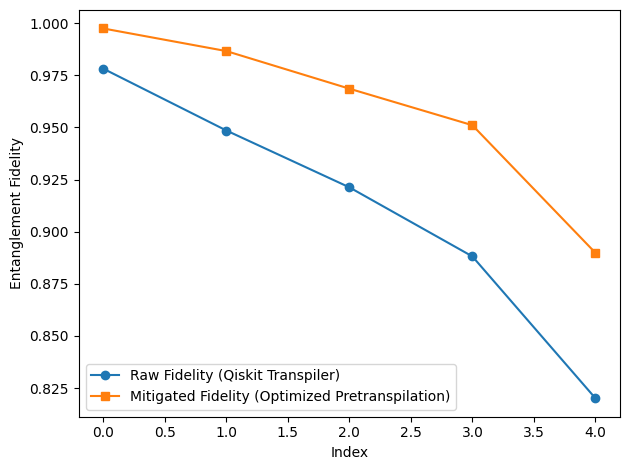

In [36]:
import matplotlib.pyplot as plt

# unzip the list of [f_raw, f_mit]
f_raw_vals = [x[0] for x in entanglement_fidelities]
f_mit_vals = [x[1] for x in entanglement_fidelities]

x = range(len(entanglement_fidelities))

plt.figure()
plt.plot(x, f_raw_vals, 'o-', label="Raw Fidelity (Qiskit Transpiler)")
plt.plot(x, f_mit_vals, 's-', label="Mitigated Fidelity (Optimized Pretranspilation)")

plt.xlabel("Index")
plt.ylabel("Entanglement Fidelity")
plt.legend()
plt.tight_layout()
plt.show()
